# Ejercicio k-Nearest Neighbor

## App Reviews
En este ejercicio vas a trabajar con una base de datos de reviews de una aplicación. Entre los datos podemos encontrar el texto de la review, las estrellas, así como el sentimiento del comentario (si es algo bueno o malo).

El objetivo es montar un algoritmo de clasificación que prediga el rating, en función del sentimiento del comentario y la cantidad de palabras empleadas en el mismo. Para ello tendrás que utilizar un algoritmo de tipo KNN.

## Importamos las librerías que vamos a utilizar

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV

## Leemos nuestro archivo de entrada `reviews_sentiment`

Para facilitar el ejercicio, las columnas que utilizaremos serán: wordcount con la cantidad de palabras utilizadas y sentimentValue con un valor entre -4 y 4 que indica si el comentario fue valorado como positivo o negativo

Nuestras etiquetas, serán las estrellas que dieron los usuarios a la app, que son valores discretos del 1 al 5

In [8]:
df = pd.read_csv("data/reviews_sentiment.csv", sep=';')
df.head

<bound method NDFrame.head of                    Review Title  \
0                  Sin conexión   
1                  faltan cosas   
2    Es muy buena lo recomiendo   
3               Version antigua   
4                     Esta bien   
..                          ...   
252        Muy buena aplicacion   
253                       Buena   
254                        Wuau   
255                   Muy buena   
256                       Sg S5   

                                           Review Text  wordcount  \
0    Hola desde hace algo más de un mes me pone sin...         23   
1                   Han mejorado la apariencia pero no         20   
2                                 Andres e puto amoooo          4   
3    Me gustana mas la version anterior esta es mas...         17   
4                      Sin ser la biblia.... Esta bien          6   
..                                                 ...        ...   
252                                   Muy buena genial          3 

## Rápidas visualizaciones y análisis
Al menos realiza un análisis univariante y representa la distribución del rating. Realiza otras visualizaciones para ver la relación de tus datos.

C:\Users\mikel\AppData\Local\Temp\ipykernel_7740\1027631526.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Star Rating', data=df, palette='viridis')


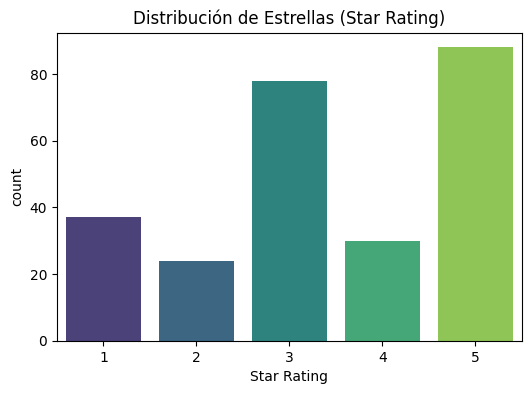

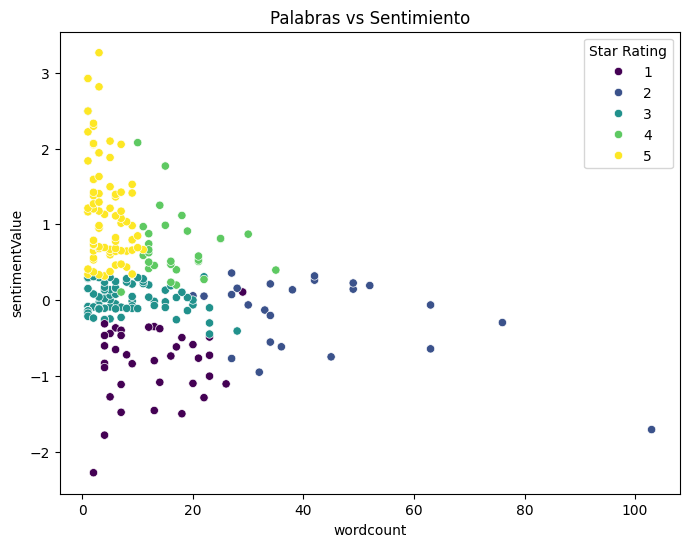

In [9]:
# Vemos cuántas reviews hay de cada puntuación (estrellas)
plt.figure(figsize=(6,4))
sns.countplot(x='Star Rating', data=df, palette='viridis')
plt.title('Distribución de Estrellas (Star Rating)')
plt.show()

# Vemos la relación entre cantidad de palabras y sentimiento, coloreado por estrellas
plt.figure(figsize=(8,6))
sns.scatterplot(x='wordcount', y='sentimentValue', hue='Star Rating', data=df, palette='viridis')
plt.title('Palabras vs Sentimiento')
plt.show()

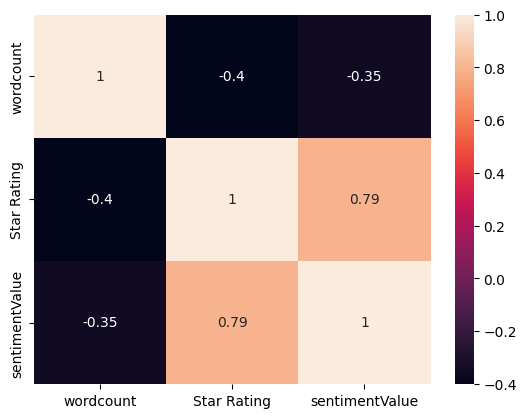

In [10]:
sns.heatmap(df.corr(numeric_only=True), annot=True);

## Preparamos el dataset
Divide en train/test y escala las features en el rango [0, 1].

In [11]:
X = df[['wordcount', 'sentimentValue']] 
y = df['Star Rating']                   # Target: puntuación por estrellas


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(205, 2)
(205,)
(52, 2)
(52,)


In [13]:
minmaxs = MinMaxScaler()

minmaxs.fit(X_train)

X_train_scaled = minmaxs.transform(X_train)
X_test_scaled = minmaxs.transform(X_test)

print(X_train_scaled.min())
print(X_train_scaled.max())

print(X_test_scaled.min())
print(X_test_scaled.max())

0.0
1.0
0.0
0.9386062900026317


## Creamos el Modelo
Entrena con un KNN y evalúa el error en train y en test

In [8]:
# Crear el modelo KNN 
knn = KNeighborsClassifier(n_neighbors = 5)

# Entrenar el modelo 
knn.fit(X_train_scaled, y_train)

# Accuracy (precisión)
train_acc = knn.score(X_train_scaled, y_train)
test_acc = knn.score(X_test_scaled, y_test)

print("Precisión en Train:", train_acc)
print("Precisión en Test:", test_acc)

Precisión en Train: 0.9365853658536586
Precisión en Test: 0.8461538461538461


## Evalúa tu modelo

--- Reporte de Clasificación (K=5) ---
              precision    recall  f1-score   support

           1       0.88      0.88      0.88         8
           2       0.71      0.83      0.77         6
           3       0.78      0.93      0.85        15
           4       1.00      0.43      0.60         7
           5       0.94      0.94      0.94        16

    accuracy                           0.85        52
   macro avg       0.86      0.80      0.81        52
weighted avg       0.86      0.85      0.84        52



<Figure size 800x600 with 0 Axes>

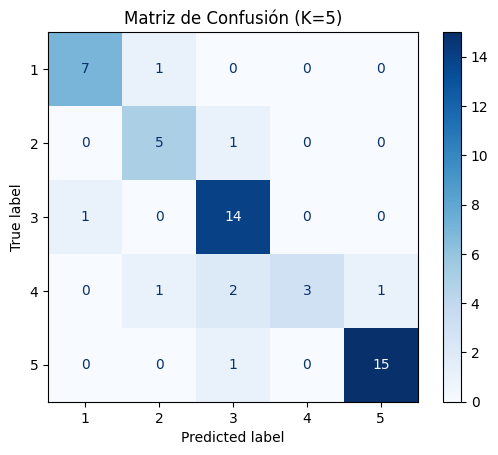

In [10]:
# Predecir con el modelo creado
y_pred_k5 = knn.predict(X_test_scaled)

# Imprimir Reporte de Clasificación
print("--- Reporte de Clasificación (K=5) ---")
print(classification_report(y_test, y_pred_k5, zero_division=0))

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_k5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión (K=5)')
plt.show()

## ¿Cómo obtener el mejor valor de k? Crea y evalúa nuevos modelos
¿Qué valor de k maximiza el accuracy? Representa todas las iteraciones en un scatterplot -> k vs accuracy

In [13]:
k_range = range(1, 20)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_scaled, y_train)
    scores.append(knn.score(X_test_scaled, y_test))
    
    print('K=',k, scores)

K= 1 [0.8653846153846154]
K= 2 [0.8653846153846154, 0.8269230769230769]
K= 3 [0.8653846153846154, 0.8269230769230769, 0.8461538461538461]
K= 4 [0.8653846153846154, 0.8269230769230769, 0.8461538461538461, 0.8269230769230769]
K= 5 [0.8653846153846154, 0.8269230769230769, 0.8461538461538461, 0.8269230769230769, 0.8461538461538461]
K= 6 [0.8653846153846154, 0.8269230769230769, 0.8461538461538461, 0.8269230769230769, 0.8461538461538461, 0.8076923076923077]
K= 7 [0.8653846153846154, 0.8269230769230769, 0.8461538461538461, 0.8269230769230769, 0.8461538461538461, 0.8076923076923077, 0.8076923076923077]
K= 8 [0.8653846153846154, 0.8269230769230769, 0.8461538461538461, 0.8269230769230769, 0.8461538461538461, 0.8076923076923077, 0.8076923076923077, 0.7884615384615384]
K= 9 [0.8653846153846154, 0.8269230769230769, 0.8461538461538461, 0.8269230769230769, 0.8461538461538461, 0.8076923076923077, 0.8076923076923077, 0.7884615384615384, 0.7884615384615384]
K= 10 [0.8653846153846154, 0.8269230769230769,

## Predice con nuevos datos.
Ejemplo: supongamos que nos llega una review de 5 palabras y sentimiento 1

In [ ]:
# Crear el nuevo dato (5 palabras, sentimiento 1)
nuevo_dato = pd.DataFrame([[5, 1]], columns = ['wordcount', 'sentimentValue'])

# Escalar el nuevo dato con 'minmaxs'
nuevo_dato_scaled = minmaxs.transform(nuevo_dato)

# Predecir
prediccion = knn_best.predict(nuevo_dato_scaled)
print(prediccion)

[5]
Dato de entrada: Wordcount=5, SentimentValue=1
La predicción final (usando K=1) es: 5 estrellas
